In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_orders = pd.read_csv("../data/FACT_Orders.csv")
df_delivery = pd.read_csv("../data/DIM_Delivery.csv")
df_products = pd.read_csv("../data/DIM_Products.csv")
df_shopping = pd.read_csv("../data/DIM_Shopping.csv")
df_customer = pd.read_csv("../data/DIM_Customer.csv")

In [ ]:
## 3.1 INTEGRAÇÃO E CRIAÇÃO DO DATAFRAME PRINCIPAL (df_principal)

# A Chave Implícita 'Id' é usada para ligar Fatos a Dimensões.

# 1. Orders + Shopping
df_principal = df_orders.merge(
    df_shopping, 
    on='Id', 
    how='left', 
    # Definindo suffixes para colunas que possam se repetir além da chave 'Id'
    suffixes=('_Orders', '_Shopping') 
)

# 2. + Customer
# O Customer_Id está sendo trazido como uma coluna de Customer, 
# mas o merge continua sendo feito por 'Id'.
df_principal = df_principal.merge(
    df_customer, 
    on='Id', 
    how='left',
    suffixes=('_Temp', '_Customer') # O suffix '_Temp' substitui o '_Orders' anterior se houver conflito
)

# 3. + Delivery
df_principal = df_principal.merge(
    df_delivery, 
    on='Id', 
    how='left',
    suffixes=('_Customer', '_Delivery')
)

# 4. + Products (Merge na Chave: Nome do Produto)
# Renomeamos para Product_Name em DIM_Products para bater com a coluna 'Product' em FACT_Orders + DIM_Shopping
df_principal = df_principal.merge(
    df_products.rename(columns={'Product_Name': 'Product'}), 
    on='Product', 
    how='left',
    suffixes=('_Delivery', '_Product') 
)

In [4]:
print("df_principal criado com sucesso.")
print(df_principal.head())

df_principal criado com sucesso.
   Id_Delivery           Order_Date  Discount  Subtotal   Total  payment  \
0            1  2025-04-12 00:52:33      0.10   3958.20 3586.28  Credito   
1            2  2025-05-05 01:02:38      0.11   1799.01 1636.64      PIX   
2            3  2025-04-27 23:05:38      0.07   2144.00 2019.82   Boleto   
3            4  2025-04-10 02:42:52      0.03    199.60  237.23   Debito   
4            5  2025-05-12 21:55:33      0.07    161.70  193.33  Credito   

  Purchase_Status Item_ID                                         Product  \
0     Processando  I00001                              Samsung Galaxy A36   
1      Em Analise  I00002                      Samsung Galaxy Tab S6 Lite   
2       Cancelado  I00003  Soundbar Samsung com 2.1 canais, Dolby Digital   
3     Processando  I00004                      Carregador Turbo USB-C 30W   
4      Em Analise  I00005                     Carregador Turbo Tipo-C 50w   

   Quantity  Price_Delivery Customer_Id      Cu

In [5]:
## 2.1 LIMPEZA E FEATURE ENGINEERING BÁSICO

# 1. Conversão de Tipos (Datas)
date_cols = ['Order_Date', 'D_Forecast', 'D_Date']
for col in date_cols:
    df_principal[col] = pd.to_datetime(df_principal[col])

# 2. Features de Tempo
df_principal['delivery_lead_time'] = (df_principal['D_Date'] - df_principal['Order_Date']).dt.days
df_principal['delivery_delay_days'] = (df_principal['D_Date'] - df_principal['D_Forecast']).dt.days
df_principal['is_late'] = (df_principal['delivery_delay_days'] > 0).astype(int)

# 3. Features Financeiras e Lógicas
df_principal['discount_abs'] = df_principal['Discount'] * df_principal['Subtotal']
df_principal['freight_share'] = df_principal['P_Sevice'] / df_principal['Total']
df_principal['is_confirmed'] = (df_principal['Purchase_Status'] == 'Confirmado').astype(int)
df_principal['is_canceled'] = (df_principal['Purchase_Status'] == 'Cancelado').astype(int)

In [ ]:
## 3.1 AGREGAÇÃO DE DADOS

# Criação do Identificador Único do Pedido
order_cols_for_group = ['Order_Date', 'Subtotal', 'Total', 'payment', 'Purchase_Status', 'Customer_Id', 'Delivery_Id']
df_principal['Unique_Order_Group'] = df_principal.groupby(order_cols_for_group).ngroup()

# Agregação dos Dados para o Nível do Pedido
df_pedidos = df_principal.groupby('Unique_Order_Group').agg(
    Receita=('Total', 'first'),
    Ticket_Medio=('Total', 'first'),
    Subtotal_Pedido=('Subtotal', 'first'),
    Desconto_Taxa=('Discount', 'first'),
    Frete_Custo=('P_Sevice', 'first'),
    Frete_Take_Rate=('freight_share', 'first'),
    
    is_atrasado=('is_late', 'max'),
    is_cancelado=('is_canceled', 'max'),
    is_confirmado=('is_confirmed', 'max'),
    
    Dias_Lead_Time_Medio=('delivery_lead_time', 'mean'),
    Dias_Atraso_Medio=('delivery_delay_days', 'mean'),
    Qtde_Total_Itens=('Quantity', 'sum'),
    Qtde_Produtos_Diferentes=('Product', 'nunique'),
    
    Data_Pedido=('Order_Date', 'first'),
    Regiao=('Region', 'first'),
    UF=('State', 'first'),
    Servico_Logistico=('Services', 'first')

).reset_index()

In [7]:
## Verificação de Integridade

print("\n--- Verificação de Valores Nulos (df_pedidos) ---")
print(df_pedidos[['Receita', 'Dias_Lead_Time_Medio', 'Dias_Atraso_Medio']].isnull().sum()) 


--- Verificação de Valores Nulos (df_pedidos) ---
Receita                 0
Dias_Lead_Time_Medio    0
Dias_Atraso_Medio       0
dtype: int64


# A análise Boxplot revelou outliers no Ticket Médio e Lead Time. Optamos por manter esses valores nas análises de Inferência e Média, pois representam transações reais de alto valor e atrasos logísticos genuínos, sendo essenciais para o tratamento estatístico da população.

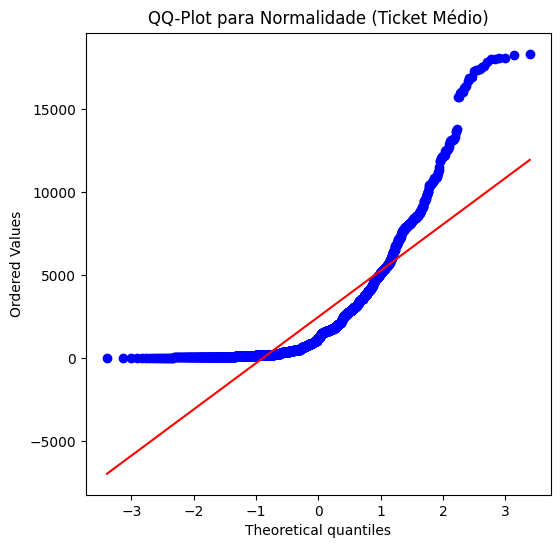

In [ ]:
## 4.0. Verificação de Suposições Estatísticas

# Usamos o QQ-Plot para visualização da normalidade do Ticket Médio.
plt.figure(figsize=(6, 6))
stats.probplot(df_pedidos['Ticket_Medio'], dist="norm", plot=plt)
plt.title("QQ-Plot para Normalidade (Ticket Médio)")
plt.show()

# O QQ-Plot mostra que a distribuição NÃO É PERFEITAMENTE NORMAL. No entanto, devido ao tamanho robusto da amostra (N=2000), o Teorema do Limite Central (TLC) se aplica, e a aproximação Normal (Teste Z) para o Intervalo de Confiança da média é estatisticamente válida, permitindo a continuação da Inferência.

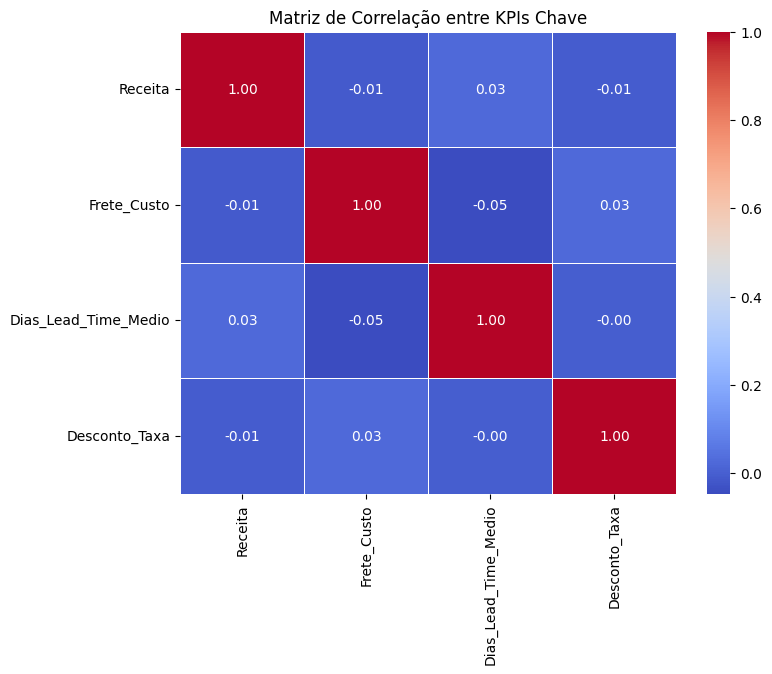

In [9]:
## 3.2.5. Heatmap de Correlação

colunas_corr = ['Receita', 'Frete_Custo', 'Dias_Lead_Time_Medio', 'Desconto_Taxa']

plt.figure(figsize=(8, 6))
sns.heatmap(
    df_pedidos[colunas_corr].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5
)
plt.title('Matriz de Correlação entre KPIs Chave')
plt.show()

C:\Users\Jonas Lima\AppData\Local\Temp\ipykernel_4904\2987322753.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_performance_service.sort_values(by='Taxa_Atraso', ascending=False),


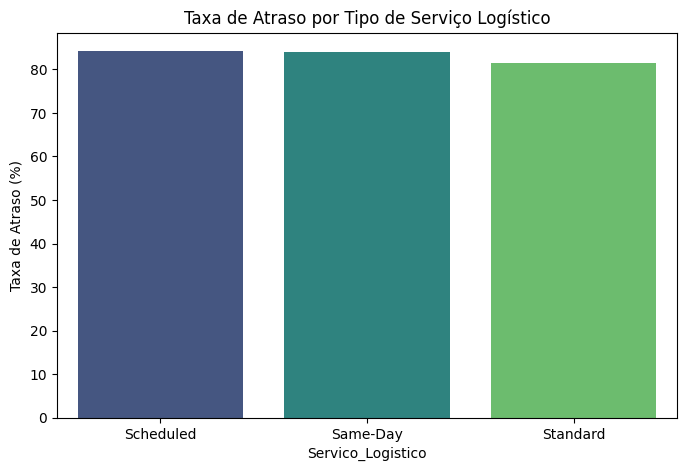

C:\Users\Jonas Lima\AppData\Local\Temp\ipykernel_4904\2987322753.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pagamento.sort_values(by='Taxa_Cancelamento', ascending=False),


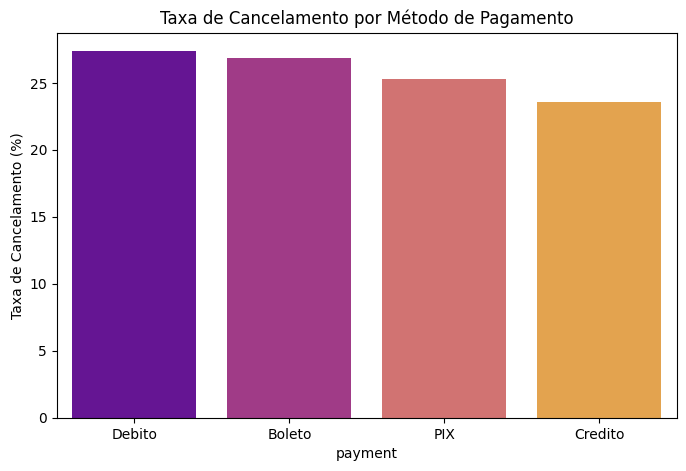

C:\Users\Jonas Lima\AppData\Local\Temp\ipykernel_4904\2987322753.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_regiao_atraso.sort_values(by='Taxa_Atraso', ascending=False),


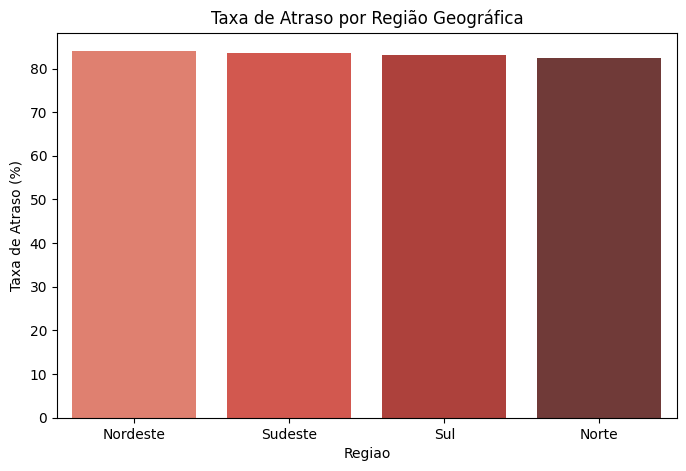

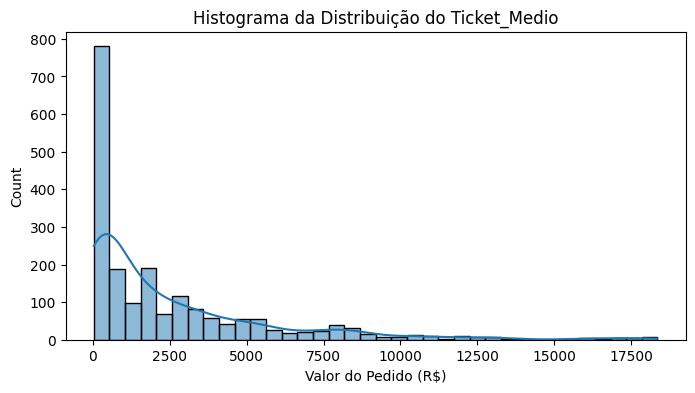

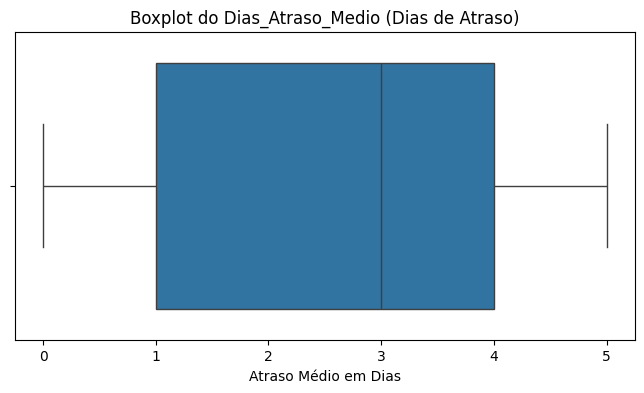

In [10]:
## 3.2.6. Análises Específicas

# 1. Performance Logística por Serviço
df_performance_service = df_pedidos.groupby('Servico_Logistico')['is_atrasado'].mean().reset_index()
df_performance_service.rename(columns={'is_atrasado': 'Taxa_Atraso'}, inplace=True)
df_performance_service['Taxa_Atraso'] = df_performance_service['Taxa_Atraso'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=df_performance_service.sort_values(by='Taxa_Atraso', ascending=False), 
            x='Servico_Logistico', y='Taxa_Atraso', palette='viridis')
plt.title('Taxa de Atraso por Tipo de Serviço Logístico')
plt.ylabel('Taxa de Atraso (%)')
plt.show()

# 2. Conversão por Tipo de Pagamento
df_pagamento = df_principal.groupby('payment')['is_canceled'].mean().reset_index()
df_pagamento.rename(columns={'is_canceled': 'Taxa_Cancelamento'}, inplace=True)
df_pagamento['Taxa_Cancelamento'] = df_pagamento['Taxa_Cancelamento'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=df_pagamento.sort_values(by='Taxa_Cancelamento', ascending=False), 
            x='payment', y='Taxa_Cancelamento', palette='plasma')
plt.title('Taxa de Cancelamento por Método de Pagamento')
plt.ylabel('Taxa de Cancelamento (%)')
plt.show()

# 3. Atraso por Região
df_regiao_atraso = df_pedidos.groupby('Regiao')['is_atrasado'].mean().reset_index()
df_regiao_atraso.rename(columns={'is_atrasado': 'Taxa_Atraso'}, inplace=True)
df_regiao_atraso['Taxa_Atraso'] = df_regiao_atraso['Taxa_Atraso'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=df_regiao_atraso.sort_values(by='Taxa_Atraso', ascending=False), 
            x='Regiao', y='Taxa_Atraso', palette='Reds_d')
plt.title('Taxa de Atraso por Região Geográfica')
plt.ylabel('Taxa de Atraso (%)')
plt.show()

# 4. Histograma do ticket Médio
kpi = 'Ticket_Medio'
plt.figure(figsize=(8, 4))
sns.histplot(df_pedidos[kpi], kde=True)
plt.title(f'Histograma da Distribuição do {kpi}')
plt.xlabel('Valor do Pedido (R$)')
plt.show()

# 5. Boxplot do Atraso de Entrega

kpi = 'Dias_Atraso_Medio'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_pedidos[kpi])
plt.title(f'Boxplot do {kpi} (Dias de Atraso)')
plt.xlabel('Atraso Médio em Dias')
plt.show()


In [11]:
## 4.1 INFERÊNCIA ESTATÍSTICA: INTERVALOS DE CONFIANÇA

# Constante Z para 95% de Confiança (N > 30, TLC se aplica)
Z_CRITICO = 1.96 
N_PEDIDOS = len(df_pedidos)

# --- A. IC para Média (Ticket Médio) ---
media_ticket = df_pedidos['Ticket_Medio'].mean()
std_ticket = df_pedidos['Ticket_Medio'].std()
margem_erro_media = Z_CRITICO * (std_ticket / np.sqrt(N_PEDIDOS))

ic_min_ticket = media_ticket - margem_erro_media
ic_max_ticket = media_ticket + margem_erro_media

# --- B. IC para Proporção (Taxa de Atraso) ---
proporcao_atraso = df_pedidos['is_atrasado'].mean() 
erro_padrao_proporcao = np.sqrt( (proporcao_atraso * (1 - proporcao_atraso)) / N_PEDIDOS )
margem_erro_proporcao = Z_CRITICO * erro_padrao_proporcao

ic_min_atraso = proporcao_atraso - margem_erro_proporcao
ic_max_atraso = proporcao_atraso + margem_erro_proporcao

print("\n--- 📊 Resultados Finais da Inferência (ICs 95%) ---")
print(f"Ticket Médio IC: R$ [{ic_min_ticket:.2f}, R$ {ic_max_ticket:.2f}]")
print(f"Taxa de Atraso IC: [{ic_min_atraso:.2%}, {ic_max_atraso:.2%}]")


--- 📊 Resultados Finais da Inferência (ICs 95%) ---
Ticket Médio IC: R$ [2360.52, R$ 2643.65]
Taxa de Atraso IC: [81.61%, 84.89%]
